In [15]:
# Install TensorFlow
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalAveragePooling2D, Dropout, Multiply, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [16]:
# Define paths to your datasets
train_dir = '/kaggle/input/undersample-majority/undersample_split/1.train'
val_dir = '/kaggle/input/undersample-majority/undersample_split/2.val'
test_dir = '/kaggle/input/undersample-majority/undersample_split/3.test'

In [17]:
# Data normalization
datagen = ImageDataGenerator(rescale=1./255)

# Load datasets with class_mode='categorical'
img_height, img_width = 380, 380  # EfficientNet-B4 input size
batch_size = 8

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 467 images belonging to 7 classes.
Found 100 images belonging to 7 classes.
Found 101 images belonging to 7 classes.


In [18]:
# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [19]:
# Define the attention mechanism
def attention_module(inputs, ratio=8):
    # Channel-wise attention
    channel_attention = GlobalAveragePooling2D()(inputs)
    channel_attention = Dense(channel_attention.shape[-1] // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(channel_attention)
    channel_attention = Dense(inputs.shape[-1], kernel_initializer='he_normal', use_bias=True)(channel_attention)
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Multiply()([inputs, channel_attention])

    # Spatial attention
    spatial_attention = Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal', use_bias=False)(channel_attention)
    spatial_attention = Multiply()([inputs, spatial_attention])

    return Add()([inputs, spatial_attention])

In [20]:
# Load the pre-trained EfficientNet-B7 model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Unfreeze some of the later layers in the base model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers, for example
    layer.trainable = True

In [22]:
# Add custom top layers for your specific task
x = base_model.output
x = attention_module(x)  # Add attention mechanism
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [23]:
# Define the model
model = Model(inputs=base_model.input, outputs=output)

In [24]:
# Compile the model with a lower learning rate
learning_rate = 1e-5
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
# Train the model with early stopping
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,  # Set a higher number of epochs, early stopping will handle it
    callbacks=[early_stopping]
)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.1535 - loss: 1.9947 - val_accuracy: 0.1354 - val_loss: 1.9701
Epoch 2/15
 1/58 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.5000 - loss: 1.4970

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.5000 - loss: 1.4970 - val_accuracy: 0.0000e+00 - val_loss: 1.9124
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 365ms/step - accuracy: 0.3070 - loss: 1.7706 - val_accuracy: 0.1250 - val_loss: 1.9605
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 1.5523 - val_accuracy: 0.0000e+00 - val_loss: 2.1188
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.4026 - loss: 1.6300 - val_accuracy: 0.1250 - val_loss: 1.9595
Training time: 318.04 seconds


In [26]:
# Evaluate the model
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # Use the classes directly

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 


In [27]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys()))

# Specificity calculation
specificity = np.mean([conf_matrix[i, i] / np.sum(conf_matrix[:, i]) for i in range(num_classes)])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Learning Rate: {learning_rate}")
print("Classification Report:\n", report)

Accuracy: 0.1386
Precision: 0.0192
Recall (Sensitivity): 0.1386
F1 Score: 0.0337
Specificity: nan
Learning Rate: 1e-05
Classification Report:
                          precision    recall  f1-score   support

         1. No DR signs       0.00      0.00      0.00        15
2. Mild (or early) NPDR       0.00      0.00      0.00        15
       3. Moderate NPDR       0.00      0.00      0.00        12
         4. Severe NPDR       0.00      0.00      0.00        15
    5. Very Severe NPDR       0.00      0.00      0.00        15
                 6. PDR       0.14      1.00      0.24        14
        7. Advanced PDR       0.00      0.00      0.00        15

               accuracy                           0.14       101
              macro avg       0.02      0.14      0.03       101
           weighted avg       0.02      0.14      0.03       101



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

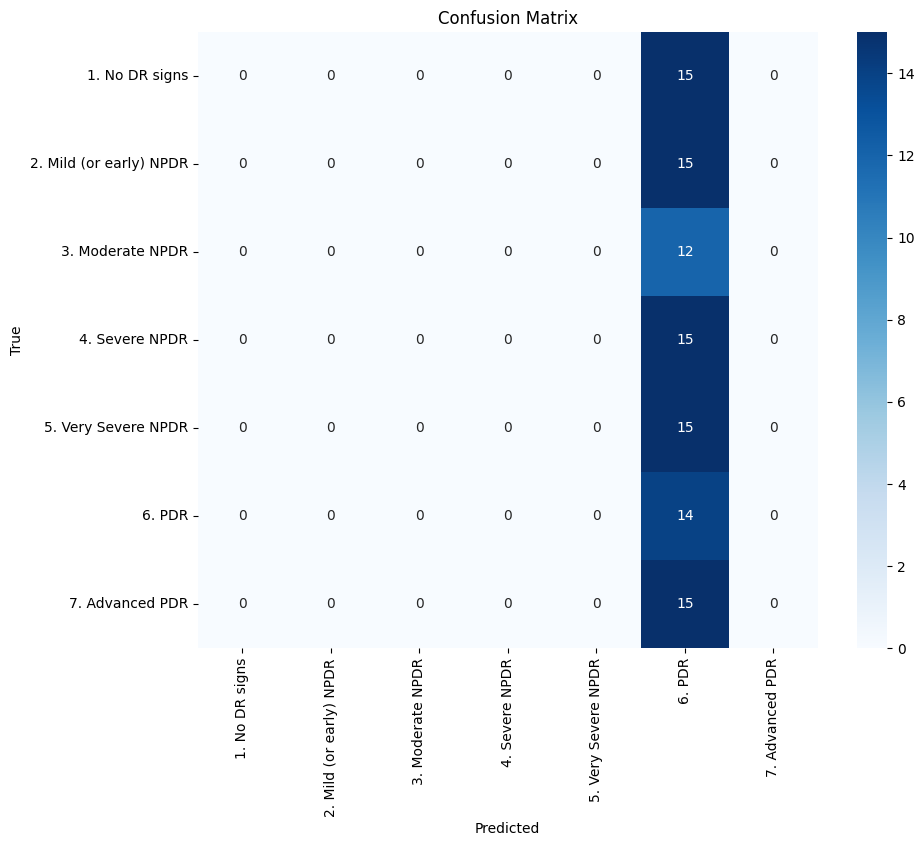

In [28]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()